**Spectral Demixing (NMF, ICA) Notebook**

In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import non_negative_factorization, FastICA
import random

In [13]:
def baseline_AsLS(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr, lam=1e4, p=0.01, niter=10):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg = baseline_AsLS(spec, lam=lam, p=p, niter=niter)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        normed = corr / nrm if nrm else corr
        normed = np.abs(normed)  # Ensure non-negative
        out[i] = normed
    return out

In [14]:
df = pd.read_csv("query_v2_multiples.csv")
feature_cols = df.columns[:-2]
spectra = df[feature_cols].values.astype(float)
labels = df[['Label 1', 'Label 2']].values

In [15]:
spectra_proc = preprocess(spectra)

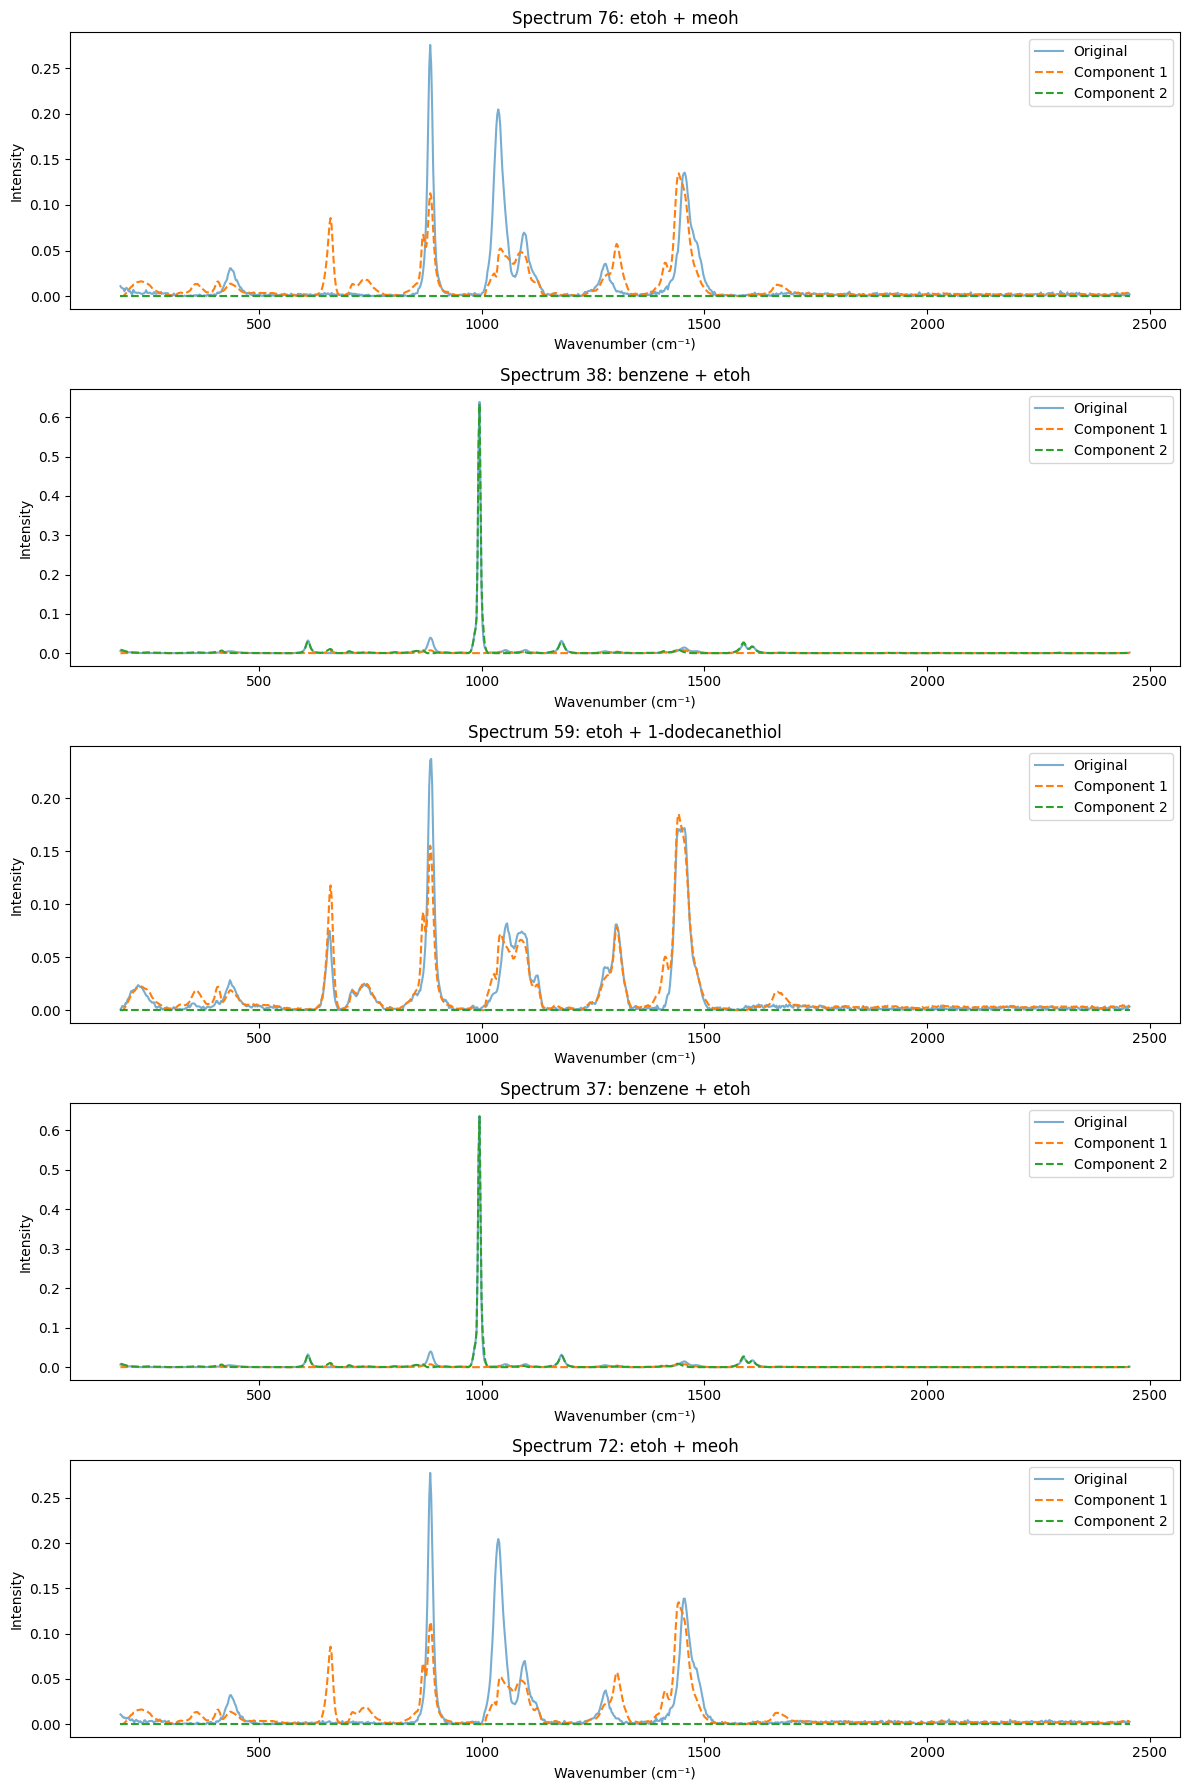

In [ ]:
W_all, H_all, _ = non_negative_factorization(spectra_proc, n_components=2, init='random', random_state=0)

# Plot 5 random examples
indices = random.sample(range(len(spectra_proc)), 5)
wavenumbers = np.array(feature_cols, dtype=float)

fig, axs = plt.subplots(5, 1, figsize=(12, 18))
for i, idx in enumerate(indices):
    axs[i].plot(wavenumbers, spectra_proc[idx], label='Original', alpha=0.6)
    axs[i].plot(wavenumbers, W_all[idx, 0] * H_all[0], label='Component 1', linestyle='--')
    axs[i].plot(wavenumbers, W_all[idx, 1] * H_all[1], label='Component 2', linestyle='--')
    axs[i].set_title(f"Spectrum {idx+1}: {labels[idx, 0]} + {labels[idx, 1]}")
    axs[i].legend()
    axs[i].set_xlabel("Wavenumber (cm⁻¹)")
    axs[i].set_ylabel("Intensity")

plt.tight_layout()
plt.show()

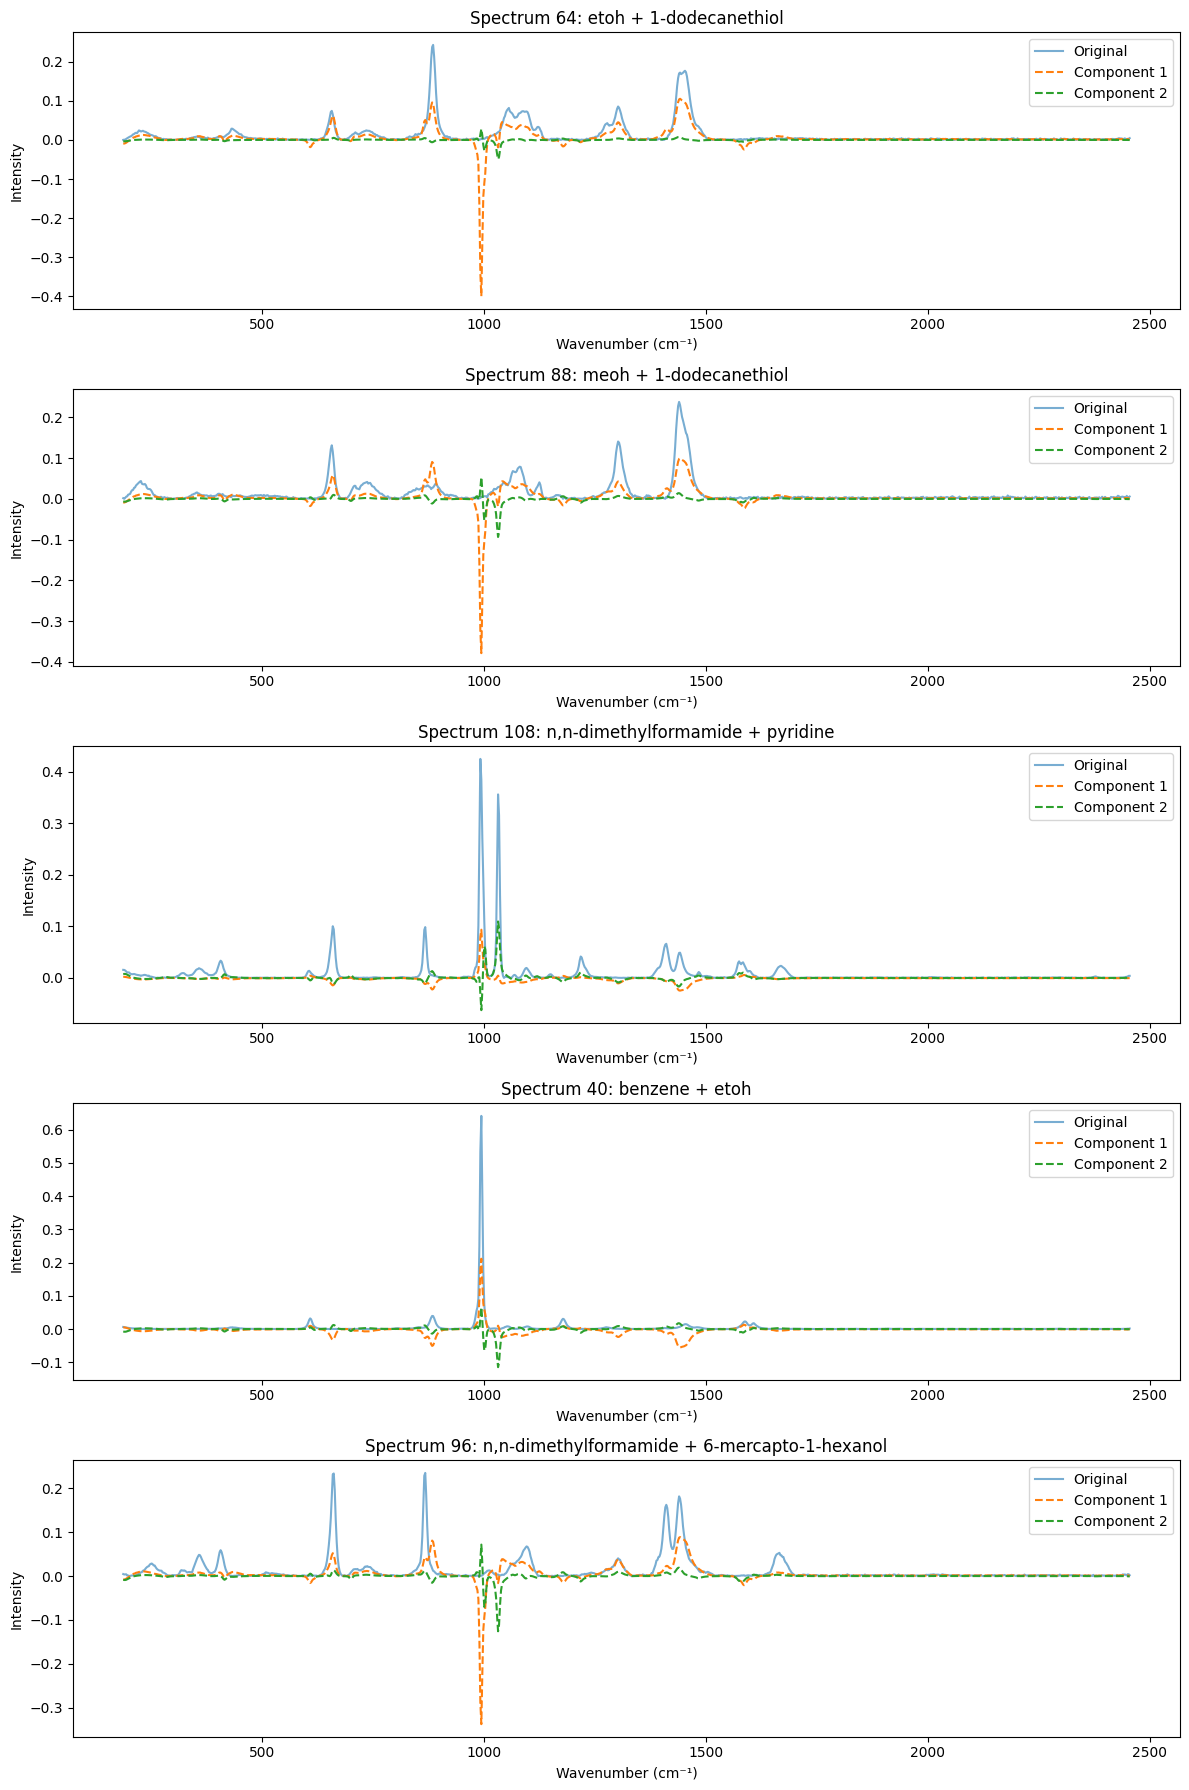

In [21]:
ica = FastICA(n_components=2, random_state=0)
S_ = ica.fit_transform(spectra_proc)   # Shape: (n_samples, 2) - mixing weights
A_ = ica.mixing_.T                     # Shape: (2, n_features) - basis components

# Plot 5 random examples
indices = random.sample(range(len(spectra_proc)), 5)
wavenumbers = np.array(feature_cols, dtype=float)

fig, axs = plt.subplots(5, 1, figsize=(12, 18))
for i, idx in enumerate(indices):
    original = spectra_proc[idx]
    comp1 = S_[idx, 0] * A_[0]
    comp2 = S_[idx, 1] * A_[1]

    axs[i].plot(wavenumbers, original, label='Original', alpha=0.6)
    axs[i].plot(wavenumbers, comp1, label='Component 1', linestyle='--')
    axs[i].plot(wavenumbers, comp2, label='Component 2', linestyle='--')
    axs[i].set_title(f"Spectrum {idx+1}: {labels[idx, 0]} + {labels[idx, 1]}")
    axs[i].legend()
    axs[i].set_xlabel("Wavenumber (cm⁻¹)")
    axs[i].set_ylabel("Intensity")

plt.tight_layout()
plt.show()